In [10]:
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import ott
from ott.geometry import pointcloud
from ott.core import sinkhorn
from ott.tools import transport

In [11]:
def create_points(rng, n, m, d):
    rngs = jax.random.split(rng, 3)
    x = jax.random.normal(rngs[0], (n,d)) + 1
    y = jax.random.uniform(rngs[1], (m,d))
    a = jnp.ones((n,)) / n
    b = jnp.ones((m,)) / m
    return x, y, a, b

rng = jax.random.PRNGKey(0)
n, m, d = 12, 14, 2
x, y, a, b = create_points(rng, n=n, m=m, d=d)

In [12]:
ot = transport.solve(x, y, a=a, b=b, epsilon=1e-2)

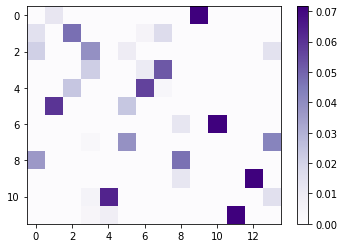

In [13]:
plt.imshow(ot.matrix, cmap='Purples')
plt.colorbar();

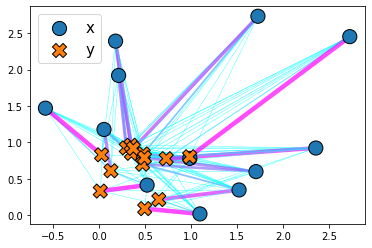

In [14]:
plott = ott.tools.plot.Plot()
_ = plott(ot)

In [15]:
def optimize(x: jnp.ndarray,
             y: jnp.ndarray,
             a: jnp.ndarray,
             b: jnp.ndarray,
             cost_fn=ott.geometry.costs.Euclidean(),
             num_iter: int = 101,
             dump_every: int = 10,
             learning_rate: float = 0.2):
    
    reg_ot_cost_vg = jax.value_and_grad(jax.jit(
      (lambda geom, a, b: ott.core.sinkhorn.sinkhorn(geom, a, b).reg_ot_cost)),
      argnums=0)

    ot = transport.solve(x, y, a=a, b=b, cost_fn=cost_fn, epsilon=1e-2, jit=True)
    result = [ot]
    for i in range(1, num_iter + 1):
        reg_ot_cost, geom_g = reg_ot_cost_vg(ot.geom, ot.a, ot.b)
        x = x - geom_g.x * learning_rate
        ot = transport.solve(x, y, a=a, b=b, cost_fn=cost_fn, epsilon=1e-2, jit=True)
        if i % dump_every == 0:
            result.append(ot)

    return result

In [16]:
ots = optimize(x, y, a, b, num_iter=100, cost_fn=ott.geometry.costs.Euclidean())

In [17]:
from IPython import display

fig = plt.figure(figsize=(8, 5))
plott = ott.tools.plot.Plot(fig=fig)
anim = plott.animate(ots, frame_rate=4)
html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()